Required libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score

# The Problem and Data Introduction

Credit card fraud is a problem in the world today. It can be devastating for people who are a victim of this fraud and get charged for something they did not purchase, especially if they can't afford it. It is important for credit card companies to be able to detect when a fraudulent transaction was made and not have the victim responsible for paying for it. We will build different models for detecting credit card fraud and compare them to find the best model.

The data we will be using has already been collected for us, as we can not get this information ourselves. The dataset contains 284,807 transactions made by European credit card holders for two days in September 2013. Since credit card data can contain a lot of personal information that shouldn't be exposed, the data has already been transformed for us using Principal Component Analysis (PCA) transformation. There are 28 transformed features, labeled 'V1' through 'V28', and 3 non-transformed features. The non-transformed features are 'Time' which is the time between transactions in seconds, which will not be used for this analysis, 'Amount' which is the total amount of each transaction, and 'Class' which is whether the transaction is fraud (labeled '1') or not fraudulent (labeled '0').

It is unfortunate that the dataset is transformed and we don't know the original information, however it is better to use real world data than simulated data to build and test our models.

# Exploratory Data Analysis

In [2]:
# Load Data

credit_card = pd.read_csv("../input/creditcardfraud/creditcard.csv")

In [3]:
# Initial Look

credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Looking at the outputs above, we see the first five rows of our dataset and some basic information about the features. Fortunately, the dataset contains no missing values so there will be minimum data cleaning to do.

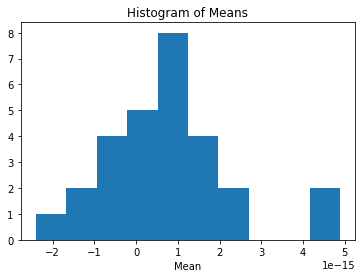

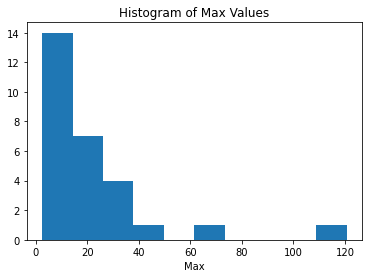

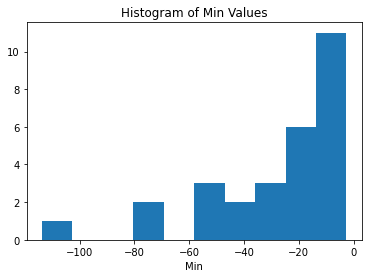

In [5]:
# PCA Features Histograms

mean_values = credit_card.iloc[:,1:29].mean(axis=0)
plt.hist(mean_values)
plt.title("Histogram of Means")
plt.xlabel("Mean")
plt.show()

max_values = credit_card.iloc[:,1:29].max(axis=0)
plt.hist(max_values)
plt.title("Histogram of Max Values")
plt.xlabel("Max")
plt.show()

min_values = credit_card.iloc[:,1:29].min(axis=0)
plt.hist(min_values)
plt.title("Histogram of Min Values")
plt.xlabel("Min")
plt.show()

The histograms above were created using the features that were PCA transformed. The mean values for these features are approximately normally distribution with the mean slightly less than 1. The max values are right skewed ranging from 0 to 120 and the min values are left skewed ranging from -120 to 0. The data appears to have been transformed properly.

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


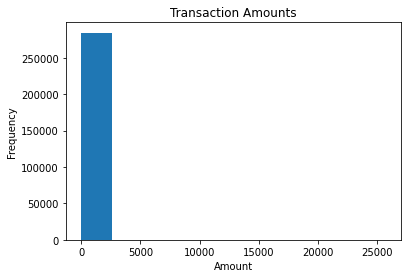

In [6]:
# Transaction Amounts Histogram

print(credit_card['Amount'].describe())
plt.hist(credit_card['Amount'])
plt.title("Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

As we can see by the summary statistics and histogram of transaction amounts, there appears to be a very extreme outlier at 25691.16, and possibly more very high points that aren't noticeable. Because of its extremity, we can already guess this point is a fraudulent transaction. We will keep this point in the data for modeling as outliers like this may help with clustering, but for the purpose of exploratory data analysis of transaction amounts, we will not include any extreme points, and we'll subset the 'Amount' data to values less than 2,500.

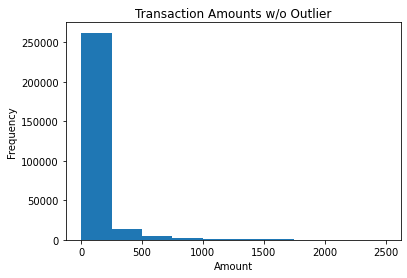

In [7]:
# Transaction Amounts Histogram

amount_temp = [a for a in credit_card['Amount'] if a <= 2500]
plt.hist(amount_temp)
plt.title("Transaction Amounts w/o Outlier")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

As we can see by the histogram, the Transaction Amount is heavily right-skewed, with the vast majority of transactions being between 0 and 250 euros, which makes sense for credit card data.

0    284315
1       492
Name: Class, dtype: int64


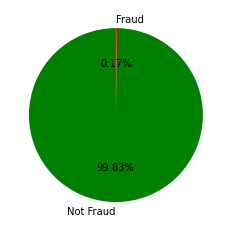

In [8]:
# Fraud Class Label Distribution

print(credit_card['Class'].value_counts())
plt.pie(credit_card['Class'].value_counts(), labels = ['Not Fraud','Fraud'], 
        autopct = '%1.2f%%', startangle = 90, colors = ['Green','Red'])
plt.show()

Looking at the pie chart, our data is extremely unbalanced with only 0.17% (492 out of 284,807) of the data being fraudelent transactions. Because of this great imbalance, the accuracies of models will be very high. It will be tough to conclude how our models performed, but we can still look at the accuracy to compare models to determine if certain models are better for detecting fraud.

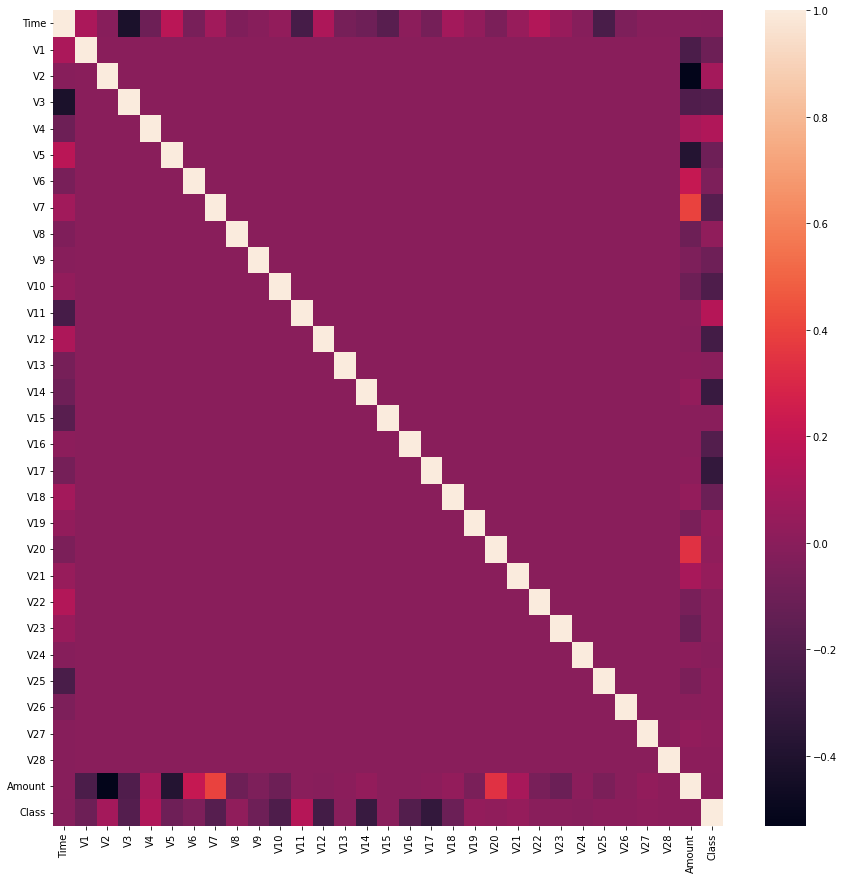

In [9]:
# Correlation Matrix

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(credit_card.corr(), ax=ax)
plt.show()

The correlation plot looks great. None of the features appear to be correlated with each other, so there won't be any correlated features that need to be removed.

# Data Preprocessing

Most of the data cleaning and preprocessing work is already done. There are no missing values that need to be dealt with, no correlated features need to be removed, and the features are already transformed for us using Principal Component Analysis (PCA). We'll set our x_data to the 28 transformed features and the 'Amount' and the_y data will be the 'Class'.

In [10]:
# Splitting the data

x_data = credit_card.iloc[:,1:30]
y_data = credit_card['Class']

# Model Building

Since this is unsupervised learning, we'll only use our 'x_data' to build three models using different methods: K-Means, Hierarchical/Agglomerative Clustering, and Non-Negative Matrix Factorization. We'll calculate the accuracy of these models on the 'y_data' and compare the models to determine if one method is better at detecting credit card fraud than the others.

Our first model will use K-Means clustering. K-Means clustering starts with a specified number of centroids, in our case it will be 2 (Fraud, not Fraud), and assigns the points to the cluster that it is closest to the centroid in distance. It will then update the centroid value to the mean of the points within that cluster. It will repeat this process until either it converges, or it reaches the specified max iterations.

In [11]:
# K-Means Model

k_means_model = KMeans(n_clusters=2).fit(x_data)

In [20]:
km_model_labels = [1 if x == 0 else 0 for x in k_means_model.labels_]
labels, count = np.unique(km_model_labels, return_counts=True)
print(np.asarray((labels, count)).T)

[[     0 279580]
 [     1   5227]]


The K-Means model labeled 279,580 transactions as not fraudulent, and 5,227 transactions as fraud for the data.

Next we'll construct a Hierarchical/Agglomerative Clustering model. This method does not require a specified number of clusters, however with our data we know there are 2 clusters. How this method works is it measures the distance among all cluster points, merges the closest clusters, and then determines the new cluster's representative point. There are different methods/distance metrics within Hierarchical Clustering, but we will create a basic model for now. Since our dataset is very large, we will run into a memory issue if we create a model using all the data. We will have to create our model using a subset of the data. We'll randomly select 20% of the points for building our model.

In [13]:
# Hierarchical Clustering Model

x_data_sub = x_data.sample(frac=0.2, random_state=42)
hc_model = AgglomerativeClustering(n_clusters=2).fit(x_data_sub)

In [14]:
hc_model_labels = [1 if x == 0 else 0 for x in hc_model.labels_]
labels, count = np.unique(hc_model_labels, return_counts=True)
print(np.asarray((labels, count)).T)

[[    0 54106]
 [    1  2855]]


The Hierarchical Clustering model labeled 54,106 transactions as not fraudulent, and 2,855 as fraud for our subsample of the data.

Our third model will use Non-Negative Matrix Factorization (NMF). This method only works with non-negative data so we will need to transform our data to make all the values positive. Since the data is already transformed, we'll just shift the data by adding 120 to all the points to make everything positive. The NMF method finds two non-negative matrices whose product approximates the real values.

In [15]:
# NMF Model

x_data_trans = x_data+120
nmf_model = NMF(n_components=2, init = 'random', random_state = 42).fit(x_data_trans)

In [16]:
nmf_features = nmf_model.transform(x_data_trans)
nmf_model_labels = [1 if x == 0 else 0 for x in pd.DataFrame(nmf_features).idxmax(axis=1)]
labels, count = np.unique(nmf_model_labels, return_counts=True)
print(np.asarray((labels, count)).T)

[[     0 265962]
 [     1  18845]]


The NMF model labeled 265,962 transactions as non-fraudulent, and 18,845 as fraud for the dataset.

# Results

At first glance of the label counts, it appears that the K-Means model performed the best of the three as it had the highest proportion of non-fraudulent transactions. Let's calculate the accuracy for our three models when compared to the true labels.

In [23]:
# K-Means accuracy
km_acc = round(accuracy_score(y_data, km_model_labels),4)

# Hierarchical accuracy
hc_acc = round(accuracy_score(y_data.loc[x_data_sub.index], hc_model_labels),4)

# NMF accuracy
nmf_acc = round(accuracy_score(y_data, nmf_model_labels),4)

In [24]:
results = pd.DataFrame([km_acc,hc_acc,nmf_acc],['K-Means','Hierarchical','NMF'],['Accuracy'])
print(results)

              Accuracy
K-Means         0.9800
Hierarchical    0.9486
NMF             0.9326


As we thought, our K-Means model performed the best producing the highest accuracy of 0.98. While our Hierarchical model had an accuracy of 0.9486 and our NMF model had the lowest accuracy of 0.9326.

# Conclusion

With all three models having an accuracy above 90%, it would seem like they were all good models, however as we mentioned before, the data was extremely unbalanced since it is credit card fraud data. We can conclude with confidence that our K-Means model performed better than our Hierarchical and NMF models. Considering this type of problem is binary classification, it was expected that clustering models such as K-Means would perform better than Matrix Factorization models such as NMF.

It is hard to say exactly how well the K-Means modeled performed considering the context of the problem. With the credit card fraud data we had, 99.83% of it was non-fraudulent, so ideally we would probably want our model to have at least 99.5% accuracy. Our K-Means model had 98% accuracy so we would think our model performed pretty well. Looking at the model's classification, it labeled 5,227 (1.8%) of the transactions as fraud. If this model was used in the real world by a credit card company, humans would most likely have to look at all those transactions to determine if they are actually fraud. Considering this data was collected only 2 days, that's a lot of transactions to go through, so we would want a higher accuracy model.

In the future, there are a few things we can do to attempt to improve our model. It would be ideal if we could get data that hasn't been transformed first so we can do our own transformation, but that is unrealistic unless we work for a credit card company. Other things we can do is play around with the models' parameters. K-Means has different algorithms that can be tried to improve our model. Although the Hierarchical model didn't perform as well, it also has different linkage methods and distance metrics that we can alter to see if any combination is better than our K-Means model.

# References

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud